<a href="https://colab.research.google.com/github/vannestn/LSTM-Human-Activity-Recognition/blob/master/LSTM_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction:
This work expands upon the efforts of Guillaume Chevalier:
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016,
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

Guillaume used a TensorFlow version 1.x model that achieved 91% accuracy to classify motion data. In this notebook I have reused code from their introduction and data wrangling efforts, before defining my own CNN-DNN model with TensorFlow version 2. Sections that used Guillaume's code are annotated for clarity.

My model achieved 92.1% accuracy with validation data. Reviewing graphs, you will se that training and validation accuracies remain relatively in sync, which suggests minimal overfitting.





## Setup Environment for Running in Google Colab
This step is done because some local environments may not have a GPU, and so running this notebook in colab allows users to mount a T4 GPU cheaply in order to speed up the training process

In [36]:
import os

try:
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive')

    # Change to what you expect to be the notebook's directory
    # based on your common directory structure
    GITHUB_FOLDER_PATH = '/content/drive/My Drive/Colab_Notebooks/github/'
    REPO_NAME = 'LSTM-Human-Activity-Recognition'
    os.chdir(os.path.join(GITHUB_FOLDER_PATH, REPO_NAME))
    print(f"Changed directory to {os.getcwd()}")

except ImportError:
    # Local environment (like running in VS Code)
    notebook_path = os.getcwd()
    print(f"Running on local machine, current directory is {notebook_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Changed directory to /content/drive/My Drive/Colab_Notebooks/github/LSTM-Human-Activity-Recognition


### (Authored by Guillaume Chevalier)
# <a title="Activity Recognition" href="https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition" > LSTMs for Human Activity Recognition</a>

Human Activity Recognition (HAR) using smartphones dataset and an LSTM RNN. Classifying the type of movement amongst six categories:
- WALKING,
- WALKING_UPSTAIRS,
- WALKING_DOWNSTAIRS,
- SITTING,
- STANDING,
- LAYING.

Compared to a classical approach, using a Recurrent Neural Networks (RNN) with Long Short-Term Memory cells (LSTMs) require no or almost no feature engineering. Data can be fed directly into the neural network who acts like a black box, modeling the problem correctly. [Other research](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names) on the activity recognition dataset can use a big amount of feature engineering, which is rather a signal processing approach combined with classical data science techniques. The approach here is rather very simple in terms of how much was the data preprocessed.

Let's use Google's neat Deep Learning library, TensorFlow, demonstrating the usage of an LSTM, a type of Artificial Neural Network that can process sequential data / time series.

## Video dataset overview

Follow this link to see a video of the 6 activities recorded in the experiment with one of the participants:

<p align="center">
  <a href="http://www.youtube.com/watch?feature=player_embedded&v=XOEN9W05_4A
" target="_blank"><img src="http://img.youtube.com/vi/XOEN9W05_4A/0.jpg"
alt="Video of the experiment" width="400" height="300" border="10" /></a>
  <a href="https://youtu.be/XOEN9W05_4A"><center>[Watch video]</center></a>
</p>

## Details about the input data

I will be using an LSTM on the data to learn (as a cellphone attached on the waist) to recognise the type of activity that the user is doing. The dataset's description goes like this:

> The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used.

That said, I will use the almost raw data: only the gravity effect has been filtered out of the accelerometer  as a preprocessing step for another 3D feature as an input to help learning. If you'd ever want to extract the gravity by yourself, you could fork my code on using a [Butterworth Low-Pass Filter (LPF) in Python](https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform) and edit it to have the right cutoff frequency of 0.3 Hz which is a good frequency for activity recognition from body sensors.

## What is an RNN?

As explained in [this article](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), an RNN takes many input vectors to process them and output other vectors. It can be roughly pictured like in the image below, imagining each rectangle has a vectorial depth and other special hidden quirks in the image below. **In our case, the "many to one" architecture is used**: we accept time series of [feature vectors](https://www.quora.com/What-do-samples-features-time-steps-mean-in-LSTM/answer/Guillaume-Chevalier-2) (one vector per [time step](https://www.quora.com/What-do-samples-features-time-steps-mean-in-LSTM/answer/Guillaume-Chevalier-2)) to convert them to a probability vector at the output for classification. Note that a "one to one" architecture would be a standard feedforward neural network.

> <a href="https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm" ><img src="https://raw.githubusercontent.com/Neuraxio/Machine-Learning-Figures/master/rnn-architectures.png" /></a>
> [Learn more on RNNs](https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm)

## What is an LSTM?

An LSTM is an improved RNN. It is more complex, but easier to train, avoiding what is called the vanishing gradient problem. I recommend [this course](https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm) for you to learn more on LSTMs.

> [Learn more on LSTMs](https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm)



### (Authored by Nick Van Nest)
## Import Packages

In [37]:
import sys
sys.executable

'/usr/bin/python3'

In [38]:
# All Includes
import sys
!{sys.executable} -m pip install scikit_learn


import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
from tensorflow.keras import regularizers

from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import os

### (Modified work taken from Guillaume Chevalier)
## Define Constants to Describe Input Data Features and Labels

In [39]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

### (Modified work taken from Guillaume Chevalier)
## Let's start by downloading the data:

In [40]:
DATA_PATH = "data/"

!pwd && ls
os.chdir(DATA_PATH)
!pwd && ls

!python download_dataset.py

!pwd && ls
os.chdir("..")
!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)


/content/drive/My Drive/Colab_Notebooks/github/LSTM-Human-Activity-Recognition
data		     mae_and_loss_last_80_percent_model1.png
LICENSE		     mae_and_loss_model1.png
LSTM_files	     README.md
LSTM_new.ipynb	     training_validation_metrics_model1.png
LSTM_original.ipynb
/content/drive/My Drive/Colab_Notebooks/github/LSTM-Human-Activity-Recognition/data
 download_dataset.py   source.txt	 'UCI HAR Dataset.zip'
 __MACOSX	      'UCI HAR Dataset'

Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.

/content/drive/My Drive/Colab_Notebooks/github/LSTM-Human-Activity-Recognition/data
 download_dataset.py   source.txt	 'UCI HAR Dataset.zip'
 __MACOSX	      'UCI HAR Dataset'
/content/drive/My Drive/Colab_Notebooks/github/LSTM-Human-Activity-Recognition
data		     mae_and_loss_last_80_percent_model1.png
LICENSE		     mae_and_loss_model1.png
LSTM_files	     README.md
LSTM_new.ipynb	     training_validation_metrics_m


### (Modified work taken from Guillaume Chevalier)
## Preparing dataset:


In [41]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

TRAIN = "train/"
TEST = "test/"

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


### (The code below was authored by Nick Van Nest)
## Define Utility Functions


In [42]:
import tensorflow as tf

def one_hot(y_, n_classes):
    # This function was taken with modification from Guillaume Chevalier)
    # Function to encode neural one-hot output labels from number indexes
    # e.g.:
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]

    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

def prepare_dataset(features, labels, batch_size, shuffle_buffer_size=1000):
    """
    Prepare a shuffled and batched tf.data.Dataset given features and labels.

    Args:
    - features (ndarray): The feature data; shape should be (num_samples, 128, 9).
    - labels (ndarray): The label data; shape should be (num_samples, 5).
    - batch_size (int): Size of each batch.
    - shuffle_buffer_size (int): Size of shuffle buffer.

    Returns:
    - dataset (tf.data.Dataset): Shuffled and batched dataset.
    """

    # Create a tf.data.Dataset object from the features and labels
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))

    # Shuffle the dataset
    dataset = dataset.shuffle(shuffle_buffer_size)

    # Batch the data
    dataset = dataset.batch(batch_size)

    # Using prefetch to improve performance
    dataset = dataset.prefetch(1)

    return dataset

def plot_lr_vs_loss(epochs, lr_loss_logger):
    # Use learning rates logged by custom logger
    lrs = lr_loss_logger.learning_rates

    # Use losses logged by custom logger
    losses = lr_loss_logger.losses

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.semilogx(lrs, losses)
    plt.tick_params('both', length=10, width=1, which='both')
    plt.axis([min(lrs), max(lrs), min(losses), max(losses)])
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate vs Loss')
    plt.show()

    return #np.array([lrs, losses]).T

def plot_series_dual_y(x, y1, y2, title=None, xlabel=None, ylabel1=None, ylabel2=None, legend1=None, legend2=None, filename=None):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(ylabel2, color=color)
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    if legend1 or legend2:
        ax1.legend([legend1], loc='upper left')
        ax2.legend([legend2], loc='upper right')

    plt.title(title)
    fig.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_training_validation_metrics(history, title, filename=None):
    # Inline plots
    %matplotlib inline

    # Font settings
    font = {
        'weight': 'bold',
        'size': 18
    }
    plt.rc('font', **font)

    # Figure size
    plt.figure(figsize=(12, 12))

    # Extract training and validation metrics from history object
    train_mae = history.history['mae']
    train_loss = history.history['loss']
    val_mae = history.history['val_mae']
    val_loss = history.history['val_loss']

    # Create epoch axis and plot training metrics
    epochs = range(1, len(train_mae) + 1)
    plt.plot(epochs, train_mae, 'b--', label='Training MAE')
    plt.plot(epochs, train_loss, 'r--', label='Training Loss')

    # Plot validation metrics
    plt.plot(epochs, val_mae, 'b-', label='Validation MAE')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')

    # Labels and title
    plt.title(title)
    plt.legend(loc='upper right', shadow=True)
    plt.ylabel('Progress (MAE or Loss values)')
    plt.xlabel('Epoch')

    # Save the plot if filename is provided
    if filename:
        plt.savefig(filename)

    # Show the plot
    plt.show()

def print_classification_metrics(X, y_true_oh, model, average_method="weighted"):
    # Make predictions on the original ordered data
    predictions_prob = model.predict(X)
    predictions = np.argmax(predictions_prob, axis=1)

    # Converting one-hot encoded y_test to label encoded
    true_labels = np.argmax(y_true_oh, axis=1)

    # Calculating metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average=average_method)
    recall = recall_score(true_labels, predictions, average=average_method)
    f1 = f1_score(true_labels, predictions, average=average_method)

    print(f"Testing Accuracy: {accuracy * 100}%")
    print(f"Precision: {precision * 100}%")
    print(f"Recall: {recall * 100}%")
    print(f"F1 Score: {f1 * 100}%")

def plot_normalized_confusion_matrix(X, y_true_oh, model, labels, cmap=plt.cm.rainbow):
    # Make predictions on the original ordered data
    predictions_prob = model.predict(X)
    predictions = np.argmax(predictions_prob, axis=1)

    # Converting one-hot encoded y_test to label encoded
    true_labels = np.argmax(y_true_oh, axis=1)

    # Generate confusion matrix
    confusion_mtx = confusion_matrix(true_labels, predictions)
    normalised_confusion_matrix = np.array(confusion_mtx, dtype=np.float32)/np.sum(confusion_mtx)*100

    # Create a plot
    plt.figure(figsize=(8, 8))
    plt.imshow(normalised_confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix (Normalized)")
    plt.colorbar()

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## Define Callback Functions to Modify Training

In [43]:
def lr_scheduler(epoch, lr, initial_lr=1e-6, final_lr=1e-2, epochs=10):
    factor = (final_lr / initial_lr) ** (1 / (epochs - 1))
    return initial_lr * (factor ** epoch)

class LearningRateLossLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.learning_rates.append(lr)
        self.losses.append(logs['loss'])

class StopAtThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold  # Threshold for stopping the training

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy > self.threshold:
            print(f"\nReached {self.threshold * 100}% validation accuracy. Stopping training.")
            self.model.stop_training = True

In [44]:
TRAINING_BATCH_SIZE = 512
TESTING_BATCH_SIZE = 32
NUMBER_OF_CLASSES = 6
WINDOW_SIZE = len(X_train[0])
TIME_STEP_PARAMETER_SIZE = len(X_train[0][0])

# Prepare the dataset
y_train_oh = one_hot(y_train, NUMBER_OF_CLASSES)
y_test_oh = one_hot(y_test, NUMBER_OF_CLASSES)
prepared_training = prepare_dataset(X_train, y_train_oh, TRAINING_BATCH_SIZE)
prepared_testing = prepare_dataset(X_test, y_test_oh, TESTING_BATCH_SIZE)


In [45]:
# Build the Model
def create_model_v1():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                        strides=1,
                        activation="relu",
                        padding='causal',
                        kernel_regularizer=regularizers.l2(0.001),
                        input_shape=[WINDOW_SIZE, TIME_STEP_PARAMETER_SIZE]),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation="softmax"),
  ])
  return model

def create_model_v2():
  model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=[WINDOW_SIZE, TIME_STEP_PARAMETER_SIZE], activation='tanh'),
    tf.keras.layers.LSTM(64, activation='tanh'),
    tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation="softmax"),
  ])
  return model

# Print the model summary
model = create_model_v1()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 128, 64)           1792      
                                                                 
 lstm_2 (LSTM)               (None, 128, 128)          98816     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)               

## Determine the optimal learning rate for the model

Epoch 1/30
15/15 [==============================] - 13s 237ms/step - loss: 1.9558 - accuracy: 0.1508 - val_loss: 1.9522 - val_accuracy: 0.1218 - lr: 1.0000e-05
Epoch 2/30
15/15 [==============================] - 2s 142ms/step - loss: 1.9527 - accuracy: 0.1647 - val_loss: 1.9468 - val_accuracy: 0.2209 - lr: 1.3738e-05
Epoch 3/30
15/15 [==============================] - 2s 151ms/step - loss: 1.9450 - accuracy: 0.1817 - val_loss: 1.9388 - val_accuracy: 0.2090 - lr: 1.8874e-05
Epoch 4/30
15/15 [==============================] - 2s 143ms/step - loss: 1.9362 - accuracy: 0.2140 - val_loss: 1.9270 - val_accuracy: 0.2966 - lr: 2.5929e-05
Epoch 5/30
15/15 [==============================] - 2s 143ms/step - loss: 1.9232 - accuracy: 0.2387 - val_loss: 1.9088 - val_accuracy: 0.3560 - lr: 3.5622e-05
Epoch 6/30
15/15 [==============================] - 1s 91ms/step - loss: 1.9024 - accuracy: 0.2810 - val_loss: 1.8754 - val_accuracy: 0.3627 - lr: 4.8939e-05
Epoch 7/30
15/15 [============================

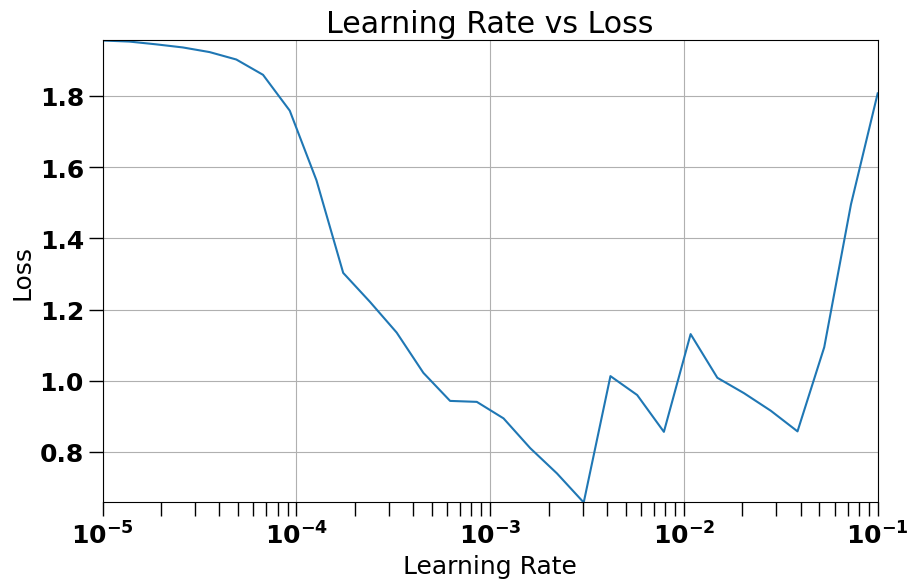

In [46]:
EPOCHS = 30

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)  # Start with the initial learning rate

# Initialize the Model
model = create_model_v1()

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=['accuracy']
              )

# Set the callbacks
lr_loss_logger = LearningRateLossLogger()
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr_scheduler(epoch, lr, initial_lr=1e-5, final_lr=1e-1, epochs=EPOCHS))

# Train the model
history = model.fit(
    prepared_training,
    epochs=EPOCHS,
    callbacks=[scheduler_callback, lr_loss_logger],
    validation_data = prepared_testing
)

# Your existing plotting function should work fine now
plot_lr_vs_loss(epochs=EPOCHS, lr_loss_logger=lr_loss_logger)


## Clear the session and use the learning rate to perform training in bulk

In [47]:
tf.keras.backend.clear_session()

EPOCHS = 150

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=5.5e-4)  # Start with the initial learning rate

# Initialize the Model
model = create_model_v1()

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=['accuracy','mae']
              )

# Set the callbacks
lr_loss_logger = LearningRateLossLogger()
stop_at_threshold = StopAtThresholdCallback(threshold=0.92)

# Train the model
history = model.fit(
    prepared_training,
    epochs=EPOCHS,
    callbacks=[lr_loss_logger, stop_at_threshold],
    validation_data = prepared_testing
)

Epoch 1/150
15/15 [==============================] - 7s 138ms/step - loss: 1.8765 - accuracy: 0.3224 - mae: 0.2722 - val_loss: 1.6116 - val_accuracy: 0.5124 - val_mae: 0.2459
Epoch 2/150
15/15 [==============================] - 1s 80ms/step - loss: 1.4877 - accuracy: 0.4687 - mae: 0.2212 - val_loss: 1.2460 - val_accuracy: 0.5131 - val_mae: 0.1959
Epoch 3/150
15/15 [==============================] - 2s 135ms/step - loss: 1.3253 - accuracy: 0.4973 - mae: 0.1974 - val_loss: 1.2015 - val_accuracy: 0.5528 - val_mae: 0.1886
Epoch 4/150
15/15 [==============================] - 1s 81ms/step - loss: 1.1307 - accuracy: 0.5724 - mae: 0.1796 - val_loss: 1.0059 - val_accuracy: 0.5843 - val_mae: 0.1638
Epoch 5/150
15/15 [==============================] - 1s 88ms/step - loss: 1.0385 - accuracy: 0.6062 - mae: 0.1581 - val_loss: 0.9957 - val_accuracy: 0.5626 - val_mae: 0.1589
Epoch 6/150
15/15 [==============================] - 1s 79ms/step - loss: 0.9858 - accuracy: 0.5841 - mae: 0.1586 - val_loss: 0.

## Plot Mean Absolute Error (MAE) and Loss During Training

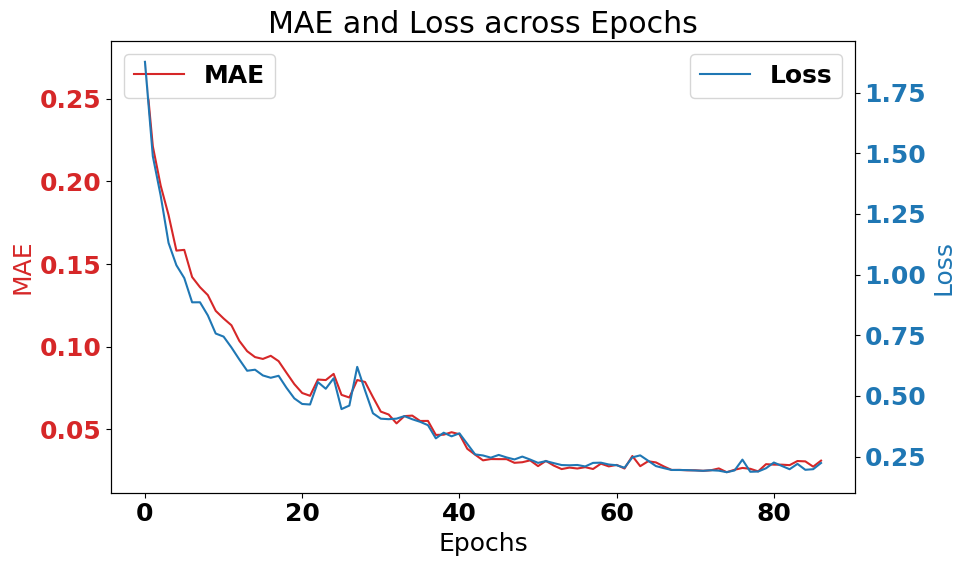

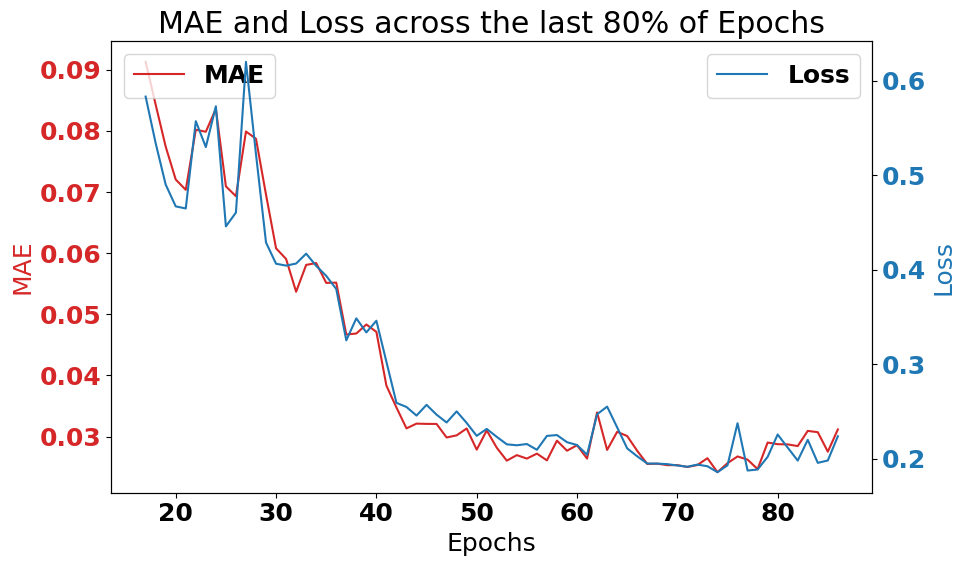

In [48]:
# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(loss))

# Plotting the full graph
plot_series_dual_y(
    x=epochs,
    y1=mae,
    y2=loss,
    xlabel='Epochs',
    ylabel1='MAE',
    ylabel2='Loss',
    legend1='MAE',
    legend2='Loss',
    title='MAE and Loss across Epochs',
    filename='mae_and_loss_model1.png')

"""Plotting the last 80% of epochs. This is done because plotting the first 20%
of epochs reduces the resolution of the graph for the latter 80%"""
zoom_split = int(len(epochs) * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

plot_series_dual_y(
    x=epochs_zoom,
    y1=mae_zoom,
    y2=loss_zoom,
    xlabel='Epochs',
    ylabel1='MAE',
    ylabel2='Loss',
    legend1='MAE',
    legend2='Loss',
    title='MAE and Loss across the last 80% of Epochs',
    filename='mae_and_loss_last_80_percent_model1.png'
)

## Monitor MAE and Loss in Training and Validation Data for any discrepancies

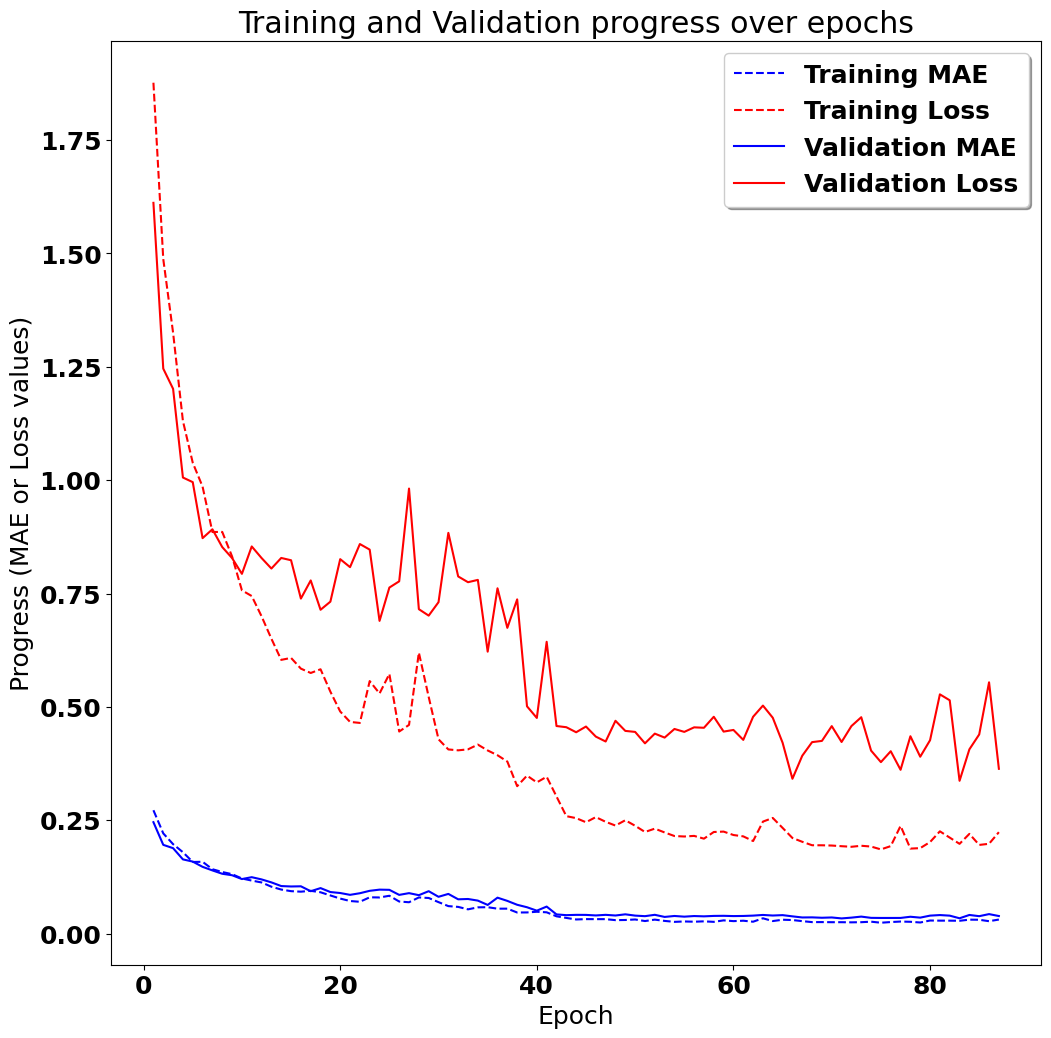

In [49]:
#%matplotlib inline
plot_training_validation_metrics(history, "Training and Validation progress over epochs", filename="training_validation_metrics_model1.png")

In [50]:
# # Extract the metrics from the history object
# train_mae = np.array(history.history['mae'])
# train_loss = np.array(history.history['loss'])
# val_mae = np.array(history.history['val_mae'])
# val_loss = np.array(history.history['val_loss'])

# # Stack them into a 2D array
# metrics_array = np.vstack([train_mae, train_loss, val_mae, val_loss])

# # If you want to transpose the array so that each row corresponds to an epoch and each column to a metric, you can do:
# metrics_array = metrics_array.T

# # print(metrics_array)


## Generate Classification Metrics to Determine Performance and Graph Confusion Matrix

93/93 [==============================] - 1s 6ms/step
Testing Accuracy: 92.09365456396336%
Precision: 92.16791653094502%
Recall: 92.09365456396336%
F1 Score: 92.073437392551%
93/93 [==============================] - 1s 5ms/step


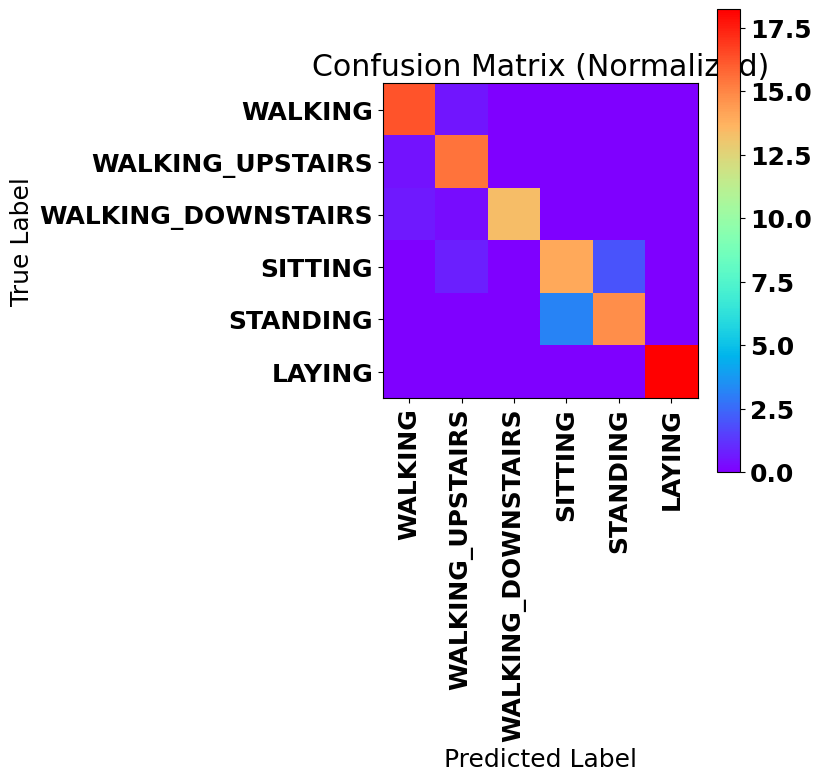

In [51]:
# Test the functions
print_classification_metrics(X_test, y_test_oh, model)
plot_normalized_confusion_matrix(X_test, y_test_oh, model, LABELS)

### (Authored by Guillaume Chevalier discussing his model)
## Conclusion

Outstandingly, **the final accuracy is of 91%**! And it can peak to values such as 93.25%, at some moments of luck during the training, depending on how the neural network's weights got initialized at the start of the training, randomly.

This means that the neural networks is almost always able to correctly identify the movement type! Remember, the phone is attached on the waist and each series to classify has just a 128 sample window of two internal sensors (a.k.a. 2.56 seconds at 50 FPS), so it amazes me how those predictions are extremely accurate given this small window of context and raw data. I've validated and re-validated that there is no important bug, and the community used and tried this code a lot. (Note: be sure to report something in the issue tab if you find bugs, otherwise [Quora](https://www.quora.com/), [StackOverflow](https://stackoverflow.com/questions/tagged/tensorflow?sort=votes&pageSize=50), and other [StackExchange](https://stackexchange.com/sites#science) sites are the places for asking questions.)

I specially did not expect such good results for guessing between the labels "SITTING" and "STANDING". Those are seemingly almost the same thing from the point of view of a device placed at waist level according to how the dataset was originally gathered. Thought, it is still possible to see a little cluster on the matrix between those classes, which drifts away just a bit from the identity. This is great.

It is also possible to see that there was a slight difficulty in doing the difference between "WALKING", "WALKING_UPSTAIRS" and "WALKING_DOWNSTAIRS". Obviously, those activities are quite similar in terms of movements.

I also tried my code without the gyroscope, using only the 3D accelerometer's 6 features (and not changing the training hyperparameters), and got an accuracy of 87%. In general, gyroscopes consumes more power than accelerometers, so it is preferable to turn them off.


## Improvements

In [another open-source repository of mine](https://github.com/guillaume-chevalier/HAR-stacked-residual-bidir-LSTMs), the accuracy is pushed up to nearly 94% using a special deep LSTM architecture which combines the concepts of bidirectional RNNs, residual connections, and stacked cells. This architecture is also tested on another similar activity dataset. It resembles the nice architecture used in "[Google’s Neural Machine Translation System: Bridging the Gap between Human and Machine Translation](https://arxiv.org/pdf/1609.08144.pdf)", without an attention mechanism, and with just the encoder part - as a "many to one" architecture instead of a "many to many" to be adapted to the Human Activity Recognition (HAR) problem. I also worked more on the problem and came up with the [LARNN](https://github.com/guillaume-chevalier/Linear-Attention-Recurrent-Neural-Network), however it's complicated for just a little gain. Thus the current, original activity recognition project is simply better to use for its outstanding simplicity.

If you want to learn more about deep learning, I have also built a list of the learning ressources for deep learning which have revealed to be the most useful to me [here](https://github.com/guillaume-chevalier/Awesome-Deep-Learning-Resources).


## References

The [dataset](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) can be found on the UCI Machine Learning Repository:

> Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.

## Citation

Copyright (c) 2016 Guillaume Chevalier. To cite my code, you can point to the URL of the GitHub repository, for example:

> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016,
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

My code is available for free and even for private usage for anyone under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE), however I ask to cite for using the code.

Here is the BibTeX citation code:
```
@misc{chevalier2016lstms,
  title={LSTMs for human activity recognition},
  author={Chevalier, Guillaume},
  year={2016}
}
```

## Extra links

### Connect with me

- [LinkedIn](https://ca.linkedin.com/in/chevalierg)
- [Twitter](https://twitter.com/guillaume_che)
- [GitHub](https://github.com/guillaume-chevalier/)
- [Quora](https://www.quora.com/profile/Guillaume-Chevalier-2)
- [YouTube](https://www.youtube.com/c/GuillaumeChevalier)
- [Dev/Consulting](http://www.neuraxio.com/en/)

### Liked this project? Did it help you? Leave a [star](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/stargazers), [fork](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/network/members) and share the love!

This activity recognition project has been seen in:

- [Hacker News 1st page](https://news.ycombinator.com/item?id=13049143)
- [Awesome TensorFlow](https://github.com/jtoy/awesome-tensorflow#tutorials)
- [TensorFlow World](https://github.com/astorfi/TensorFlow-World#some-useful-tutorials)
- And more.

---


In [52]:
# Let's convert this notebook to a README automatically for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

[NbConvertApp] WARNING | pattern 'LSTM.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execut